# <b>Brazilian E-Commerce Public Dataset by Olist</b>
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce  
<br>
![데이터 스키마](https://search.pstatic.net/sunny/?src=https%3A%2F%2Fvelog.velcdn.com%2Fimages%2Fchlalsgur96%2Fpost%2Fef840d1f-11f1-4828-b20c-ed3fbbc51dbd%2Fimage.png&type=sc960_832)

# <b>Preprocessing</b>

## Load dataset

In [336]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. 고객 데이터(customer_df)

In [337]:
customer_df = pd.read_csv('./data/olist_customers_dataset.csv')

print(f'고객 데이터 개수: {len(customer_df)}')
customer_df.head(1)

고객 데이터 개수: 99441


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [338]:
print(f'customer_id(계정) 개수: {customer_df['customer_id'].nunique()}')
print(f'customer_unique_id(사람) 수: {customer_df['customer_unique_id'].nunique()}')

customer_id(계정) 개수: 99441
customer_unique_id(사람) 수: 96096


In [339]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [340]:
# 중복값 확인
customer_df.duplicated().sum()

0

### 2. 주문 데이터(order_df)
특이사항: 한 계정에 하나의 주문밖에 없음 -> 샘플링 문제

In [341]:
order_df = pd.read_csv('./data/olist_orders_dataset.csv')

print(f'주문 데이터 개수: {len(order_df)}')
order_df.head(1)

주문 데이터 개수: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [342]:
print(f'order_id 개수: {order_df['order_id'].nunique()}')
print(f'customer_id 개수: {order_df['customer_id'].nunique()}')

order_id 개수: 99441
customer_id 개수: 99441


In [343]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


#### Change Data types(object -> datetime)

In [344]:
# datetime으로 변환할 컬럼들 지정
datetime_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

# 각 컬럼을 datetime 형식으로 변환
for col in datetime_columns:
    order_df[col] = pd.to_datetime(order_df[col], errors='coerce')

# 결과 확인
print(order_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB
None


In [345]:
for col in datetime_columns:
    print(f"NaT 개수 in {col}: {order_df[col].isnull().sum()}") # NaN -> NaT로 바뀜

NaT 개수 in order_purchase_timestamp: 0
NaT 개수 in order_approved_at: 160
NaT 개수 in order_delivered_carrier_date: 1783
NaT 개수 in order_delivered_customer_date: 2965
NaT 개수 in order_estimated_delivery_date: 0


## <b>Shipping & Delivery process</b>
주문 생성(결제 버튼 클릭 - order_purchase_timestamp) -> 결제 승인(order_approved_at)  
-> 배송사 수거(order_delivered_carrier_date) -> 고객 수령(order_delivered_customer_date)

### Check Null value

In [346]:
order_df[order_df['order_approved_at'].isnull()].head(1) # 주문 취소 -> 결제창에서 취소 or 결제 미승인 -> 결제창 최적화 연결

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12


In [347]:
order_df[order_df['order_delivered_carrier_date'].isnull()].head(1) # 배송사 수거 X -> 판매자가 전달 못함 -> 판매자 or 상품 특성 확인

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09


In [348]:
order_df[order_df['order_delivered_customer_date'].isnull()].head(1) # 고객 미수령 -> 오배송 -> 오배송률

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09


### Drop NaN value: 세션별로 drop해야할듯

#order_df = order_df.dropna() -> 결측치 전부 제거해서 주문 생성부터 고객 수령까지 완료된 데이터만 분석  

order_df = order_df.dropna(subset=['order_approved_at'])  
print(order_df.info()) # order_approved_at의 160개를 제외하고 주문 -> 결제 승인 분석

In [349]:
order_df.duplicated().sum()

0

### 3. 주문 결제 데이터(order_payments)
payment_sequential: 분할 결제 횟수  
voucher: 상품권, 할인권  
같은 주문에 금액이 다르게 나오는 건 각 결제 수단별 금액을 기록했기 때문  


In [350]:
order_payments_df = pd.read_csv('./data/olist_order_payments_dataset.csv')

print(f'주문 결제 데이터 개수: {len(order_payments_df)}')
order_payments_df.head()

주문 결제 데이터 개수: 103886


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,66
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,108
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128


In [351]:
order_payments_df['order_id'].duplicated().sum()

4446

In [352]:
# order_id가 중복된 행 전체 보기
dup_orders = order_payments_df[order_payments_df.duplicated(subset=['order_id'], keep=False)]

dup_orders.sort_values(by='order_id').head(11)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,18
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,53
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92
10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100
16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4
15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4
32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5
285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,9


In [353]:
order_payments_df[order_payments_df['order_id'] == '23fb82faac9266fd7373286d1d2fc02a']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
68804,23fb82faac9266fd7373286d1d2fc02a,1,credit_card,1,127


In [354]:
order_item_df[order_item_df['order_id'] == '23fb82faac9266fd7373286d1d2fc02a'] # 한 주문에 상품 3개

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
15727,23fb82faac9266fd7373286d1d2fc02a,1,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2017-12-01 16:37:30,33,9
15728,23fb82faac9266fd7373286d1d2fc02a,2,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2017-12-01 16:37:30,33,9
15729,23fb82faac9266fd7373286d1d2fc02a,3,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2017-12-01 16:37:30,33,9


In [355]:
print(32.99*3 + 9.34*3)

126.99


총 금액을 확인하려면 order_item_df에서 order_id별 price + freight_value을 하거나,  
order_payments_df에서 order_id별 payment_value를 더해야 함.

In [356]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


### 4. 주문 아이템 데이터(order_items)
shipping_limit_date: 배송 마감 기한 -> 배송 마감 기한, 배송 완료 시간, 배송 예측 시간 비교  
freight value: 배송비

In [357]:
order_item_df = pd.read_csv('./data/olist_order_items_dataset.csv')

print(f'주문 아이템 데이터 개수: {len(order_item_df)}')
order_item_df.head()

주문 아이템 데이터 개수: 112650


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,59,13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,240,20
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199,18
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,13,13
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,200,18


In [358]:
# order_id별 상품 수 계산
counts = order_item_df['order_id'].value_counts()

# 상품 3개인 order_id 1개 추출
counts[counts == 3].index[0]

'23fb82faac9266fd7373286d1d2fc02a'

In [359]:
order_item_df[order_item_df['order_id'] == '23fb82faac9266fd7373286d1d2fc02a'] # 한 주문에 상품 3개

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
15727,23fb82faac9266fd7373286d1d2fc02a,1,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2017-12-01 16:37:30,33,9
15728,23fb82faac9266fd7373286d1d2fc02a,2,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2017-12-01 16:37:30,33,9
15729,23fb82faac9266fd7373286d1d2fc02a,3,9ecadb84c81da840dbf3564378b586e9,1025f0e2d44d7041d6cf58b6550e0bfa,2017-12-01 16:37:30,33,9


In [360]:
print(order_df['order_id'].nunique())
print(order_item_df['order_id'].nunique())

99441
98666


In [361]:
missing_orders = set(order_df['order_id']) - set(order_item_df['order_id'])

print(len(missing_orders))
missing_orders

775


{'0010dedd556712d7bb69a19cb7bbd37a',
 '00a500bc03bc4ec968e574c2553bed4b',
 '00b1cb0320190ca0daa2c88b35206009',
 '00bca4adac549020c1273714d04d0208',
 '00d0ffd14774da775ac832ba8520510f',
 '00daac8efd71674d62356c2a306d1e4c',
 '0130f0f71fb0e831d18e6a3b33a3a50c',
 '016706d732e79b49035275c048edb2c4',
 '01cb6d702e5233235f4125309d184bf4',
 '02bfe71c2bbd56f6de9c2c357adff45c',
 '02de1e44936e56ddc1621c46d86bf91e',
 '02e723e8edb4a123d414f56cc9c4665e',
 '03227bf7c543bbee4efa38bb6c6763c8',
 '032cf17f7a713287e46999fddea6051b',
 '03310aa823a66056268a3bab36e827fb',
 '037a9cf279c376ab222c9d27be892513',
 '03d1edbd314ca7682ec0f3e67d3763e2',
 '04770bff63a120fbf0eea1f62b84f8f0',
 '04a2ba381317648726f46210a46ece95',
 '04b8c60eb3cceaecde917716daa30bde',
 '05c852fbe20c108caf9f479633cbe088',
 '05da04fd9f94dfb49fd643216d2cbe1f',
 '05e8a1fd3d354369a3de6e7230a3651f',
 '0623dbbd06c0d4059dbfefab8748a491',
 '0667c8670e40ad2783c71d45ceb361e0',
 '075cc7ce268544c780299db653d21467',
 '084d2c70d33f8b9a1e21393471844591',
 

In [362]:
order_df[order_df['order_id'] == 'feae5ecdf2cc16c1007741be785fe3cd']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
10180,feae5ecdf2cc16c1007741be785fe3cd,ca05f8b53b1ad2a64bf34baa8aa7f4f6,unavailable,2017-11-11 16:41:06,2017-11-11 16:56:15,NaT,NaT,2017-11-27


In [363]:
# 1. 상품 없는 order_id
missing_orders = set(order_df['order_id']) - set(order_item_df['order_id'])

# 2. order_df에서 해당 주문 정보 조회
missing_orders_df = order_df[order_df['order_id'].isin(missing_orders)]

# 3. 컬럼 확인
cols_to_check = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
missing_orders_df[cols_to_check].head()

,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
266,2017-11-16 15:26:57,NaT,NaT
586,2018-01-31 14:23:50,NaT,NaT
687,2017-08-17 00:15:18,NaT,NaT
737,2018-01-09 07:26:08,NaT,NaT
1130,NaT,NaT,NaT


In [364]:
# NaT 요약
missing_orders_df[cols_to_check].isnull().sum() # 고객 수령이 없는 주문이 775개 -> order_item_df는 모두 고객수령이 완료된 데이터

order_approved_at                146
order_delivered_carrier_date     774
order_delivered_customer_date    775
dtype: int64

In [365]:
order_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


#### Change Data types(object -> datetime)

In [366]:
order_item_df['shipping_limit_date'] = pd.to_datetime(order_item_df['shipping_limit_date'], errors='coerce')

# 결과 확인
print(order_item_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
None


In [367]:
order_item_df.duplicated().sum()

0

### 5. 주문 리뷰 데이터(order_reviews)

In [368]:
order_review_df = pd.read_csv('./data/olist_order_reviews_dataset.csv')

print(f'주문 데이터 개수: {len(order_df)}')
print(f'주문 리뷰 데이터 개수: {len(order_review_df)}')
order_review_df.head()

주문 데이터 개수: 99441
주문 리뷰 데이터 개수: 99224


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [369]:
order_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


#### Change Data types(object -> datetime)

In [370]:
# datetime으로 변환할 컬럼들 지정
datetime_columns = [
    'review_creation_date',
    'review_answer_timestamp'
]

# 각 컬럼을 datetime 형식으로 변환
for col in datetime_columns:
    order_review_df[col] = pd.to_datetime(order_review_df[col], errors='coerce')

# 결과 확인
print(order_review_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
None


In [371]:
order_review_df[order_review_df['order_id'].duplicated(keep=False)].sort_values(by='order_id').head(4)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04,2018-03-05 17:02:00


In [372]:
# item 1개인데 리뷰가 2개?
order_item_df[order_item_df['order_id']=='0035246a40f520710769010f752e7507']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
95,0035246a40f520710769010f752e7507,1,8a6187b2665118d5095f99a25fd7ba7a,4a3ca9315b744ce9f8e9374361493884,2017-08-23 01:25:39,87,12


In [373]:
# order_id 기준으로 리뷰 없는 주문 찾기
missing_reviews = order_df[~order_df['order_id'].isin(order_review_df['order_id'])]

print(f'리뷰 없는 주문 개수: {len(missing_reviews)}')
missing_reviews.head()

리뷰 없는 주문 개수: 768


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
16,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
311,4906eeadde5f70b308c20c4a8f20be02,4e7656e34357b93f14b40c6400ca3f6e,delivered,2017-12-08 04:45:26,2017-12-12 03:50:30,2017-12-12 17:43:21,2018-01-09 18:04:58,2018-01-03
382,b7a4a9ecb1cd3ef6a3e36a48e200e3be,c3d8fc500d86b1c961ee144395c13a57,delivered,2017-05-19 18:13:54,2017-05-20 11:35:41,2017-05-30 12:43:50,2017-06-08 07:53:42,2017-06-16
390,59b32faedc12322c672e95ec3716d614,5baa82a2c45fa3220cb57d9881db3211,delivered,2018-06-27 11:10:11,2018-06-28 02:15:51,2018-06-28 14:57:00,2018-07-06 16:37:36,2018-07-26


In [374]:
missing_reviews.order_status.value_counts()

order_status
delivered      646
shipped         75
canceled        20
unavailable     14
processing       6
invoiced         5
created          2
Name: count, dtype: int64

### 6. 상품 데이터(product_df)

In [375]:
product_df = pd.read_csv('./data/olist_products_dataset.csv')

print(f'주문 상품 데이터 개수: {len(product_df)}')
product_df.head()

주문 상품 데이터 개수: 32951


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46,250,1,154,18,9,15
3,cef67bcfe19066a932b7673e239eb23d,bebes,27,261,1,371,26,4,26
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37,402,4,625,20,17,13


In [376]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [377]:
product_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [378]:
product_df[product_df.isnull().any(axis=1)]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650,17,14,12
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300,16,7,20
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200,20,20,20
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500,41,30,41
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300,35,7,12
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800,30,20,70
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800,30,10,23
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200,21,8,16
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300,45,16,45


### Merge data(product_df, product_category_df)

In [379]:
product_category_df = pd.read_csv('./data/product_category_name_translation.csv')
product_category_df.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [380]:
# product_category_name 기준으로 왼쪽 조인
product_df = pd.merge(
    product_df,
    product_category_df,
    on='product_category_name',
    how='left'                   # product_df 기준, 없으면 NaN
)

# 결과 확인
product_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46,250,1,154,18,9,15,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27,261,1,371,26,4,26,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37,402,4,625,20,17,13,housewares


In [381]:
product_df['product_category_name_english'].isnull().sum()

623

In [382]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32328 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


### 7. 판매자 데이터(seller_df)

In [383]:
seller_df = pd.read_csv('./data/olist_sellers_dataset.csv')

print(f'판매자 데이터 개수: {len(seller_df)}')
seller_df.head()

판매자 데이터 개수: 3095


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [384]:
seller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [385]:
seller_df.duplicated().sum()

0

### 8. 위치 데이터(geolocation_df)

In [386]:
geolocation_df = pd.read_csv('./data/olist_geolocation_dataset.csv')

print(f'위치 데이터 개수: {len(geolocation_df)}')
geolocation_df.head()

위치 데이터 개수: 1000163


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-24,-47,sao paulo,SP
1,1046,-24,-47,sao paulo,SP
2,1046,-24,-47,sao paulo,SP
3,1041,-24,-47,sao paulo,SP
4,1035,-24,-47,sao paulo,SP


In [387]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [388]:
geolocation_df['geolocation_zip_code_prefix'].value_counts()

geolocation_zip_code_prefix
24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
71750       1
71742       1
26475       1
26357       1
29826       1
Name: count, Length: 19015, dtype: int64

In [389]:
# 같은 우편번호에 몇 개 좌표가 있는지 확인
geolocation_df.groupby('geolocation_zip_code_prefix')[['geolocation_lat','geolocation_lng']].nunique().head()

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,10,10
1002,6,6
1003,10,10
1004,14,14
1005,11,11


In [390]:
pd.set_option('display.float_format', '{:.0f}'.format)
geolocation_df[geolocation_df['geolocation_zip_code_prefix']==24220].describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1146,1146,1146
mean,24220,-23,-43
std,0,0,0
min,24220,-23,-43
25%,24220,-23,-43
50%,24220,-23,-43
75%,24220,-23,-43
max,24220,-23,-43


### Drop duplicate rows

In [391]:
# 그룹별 대표값 계산
geolocation_df = geolocation_df.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
    'geolocation_city': 'first', # 첫 번째 값 선택
    'geolocation_state': 'first'
}).reset_index()

print(len(geolocation_df))
geolocation_df.head()

19015


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-24,-47,sao paulo,SP
1,1002,-24,-47,sao paulo,SP
2,1003,-24,-47,sao paulo,SP
3,1004,-24,-47,sao paulo,SP
4,1005,-24,-47,sao paulo,SP


In [407]:
geolocation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 742.9+ KB


## Solution: 배송기간을 줄여 고객 만족도를 높이기 위해 fulfillment 추가

## 판매자 위치 정보

### Merge data(seller_df, geolocation_df)

In [ ]:
# geolocation_df와 seller_df의 right join
geolocation_seller_df = pd.merge(
    seller_df,
    geolocation_df,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)

geolocation_seller_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023,-23,-47,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844,-22,-47,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20031,-23,-43,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,4195,-24,-47,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,12914,-23,-47,bragança paulista,SP


In [ ]:
# select columns
geolocation_seller_df = geolocation_seller_df[['seller_id','seller_zip_code_prefix','geolocation_lat',
                                               'geolocation_lng','seller_city','seller_state']]

print(len(geolocation_seller_df))
geolocation_seller_df.head(1)

3095


,seller_id,seller_zip_code_prefix,geolocation_lat,geolocation_lng,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,-23,-47,campinas,SP


### 같은 시/도별 평균 좌표 계산 후 NaN 채우기

In [ ]:
geolocation_seller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seller_id               3095 non-null   object 
 1   seller_zip_code_prefix  3095 non-null   int64  
 2   geolocation_lat         3088 non-null   float64
 3   geolocation_lng         3088 non-null   float64
 4   seller_city             3095 non-null   object 
 5   seller_state            3095 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 145.2+ KB


In [ ]:
missing_rows = geolocation_seller_df[geolocation_seller_df.isnull().any(axis=1)]

missing_rows

,seller_id,seller_zip_code_prefix,geolocation_lat,geolocation_lng,seller_city,seller_state
473,5962468f885ea01a1b6a97a218797b0a,82040,NaN,NaN,curitiba,PR
791,2aafae69bf4c41fbd94053d9413e87ee,91901,NaN,NaN,porto alegre,RS
1672,2a50b7ee5aebecc6fd0ff9784a4747d6,72580,NaN,NaN,brasilia,DF
1931,2e90cb1677d35cfe24eef47d441b7c87,2285,NaN,NaN,sao paulo,SP
2182,0b3f27369a4d8df98f7eb91077e438ac,7412,NaN,NaN,aruja,SP
2986,42bde9fef835393bb8a8849cb6b7f245,71551,NaN,NaN,brasilia,DF
3028,870d0118f7a9d85960f29ad89d5d989a,37708,NaN,NaN,pocos de caldas,MG


In [ ]:
# 같은 시/도별 평균 좌표 계산 후 NaN 채우기
geolocation_seller_df['geolocation_lat'] = geolocation_seller_df.groupby(['seller_state','seller_city'])['geolocation_lat']\
                                    .transform(lambda x: x.fillna(x.mean()))
geolocation_seller_df['geolocation_lng'] = geolocation_seller_df.groupby(['seller_state','seller_city'])['geolocation_lng']\
                                    .transform(lambda x: x.fillna(x.mean()))

In [ ]:
# 원래 NaN이었던 행들의 인덱스 가져오기
missing_index = missing_rows.index

# geolocation_seller_df에서 해당 인덱스 행 확인
geolocation_seller_df.loc[missing_index]

,seller_id,seller_zip_code_prefix,geolocation_lat,geolocation_lng,seller_city,seller_state
473,5962468f885ea01a1b6a97a218797b0a,82040,-25,-49,curitiba,PR
791,2aafae69bf4c41fbd94053d9413e87ee,91901,-30,-51,porto alegre,RS
1672,2a50b7ee5aebecc6fd0ff9784a4747d6,72580,-16,-48,brasilia,DF
1931,2e90cb1677d35cfe24eef47d441b7c87,2285,-24,-47,sao paulo,SP
2182,0b3f27369a4d8df98f7eb91077e438ac,7412,-23,-46,aruja,SP
2986,42bde9fef835393bb8a8849cb6b7f245,71551,-16,-48,brasilia,DF
3028,870d0118f7a9d85960f29ad89d5d989a,37708,-22,-47,pocos de caldas,MG


### 판매자 위치 시각화

In [398]:
pip install folium -q



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [335]:
import folium

# 브라질 중심 좌표 (대략)
brazil_center = [-14.2350, -51.9253]

# 지도 생성
m = folium.Map(location=brazil_center, zoom_start=4)

# 판매자 위치 찍기
for idx, row in geolocation_seller_df.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)

# 지도 표시
m


## 고객 위치 정보

In [401]:
# geolocation_df와 seller_df의 right join
geolocation_customer_df = pd.merge(
    customer_df,
    geolocation_df,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)

geolocation_customer_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409,-20,-47,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,9790,-24,-47,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1151,-24,-47,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8775,-23,-46,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,13056,-23,-47,campinas,SP


In [408]:
# select columns
geolocation_customer_df = geolocation_customer_df[['customer_id','customer_unique_id', 'customer_zip_code_prefix',
                                                   'geolocation_lat', 'geolocation_lng','customer_city','customer_state']]

print(len(geolocation_customer_df))
geolocation_customer_df.head(1)

99441


,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,-20,-47,franca,SP


### 같은 시/도별 평균 좌표 계산 후 NaN 채우기

In [415]:
geolocation_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  int64  
 3   geolocation_lat           99163 non-null  float64
 4   geolocation_lng           99163 non-null  float64
 5   customer_city             99441 non-null  object 
 6   customer_state            99441 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.3+ MB


In [416]:
missing_rows = geolocation_customer_df[geolocation_customer_df.isnull().any(axis=1)]

missing_rows

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,customer_city,customer_state
354,ecb1725b26e8b8c458181455dfa434ea,b55a113bb84fc10eaf58c6d09ec69794,72300,NaN,NaN,brasilia,DF
382,bcf86029aeed4ed8bac0e16eb14c22f5,7cd7974c9f79f75b77f323878ef87f43,11547,NaN,NaN,cubatao,SP
877,f4302056f0c58570522590f8181de2c7,67b05b597a66b5c449025000b9430abb,64605,NaN,NaN,picos,PI
1218,03bbe0ce5c28e05f22917607db798818,8f3dca4306d5a89e4ae2c65c110603a2,72465,NaN,NaN,brasilia,DF
1272,ad4950aded55c2ea376be59506456d68,aa2b96dd03307ea6dc4b763c0b5f0b39,7729,NaN,NaN,caieiras,SP
...,...,...,...,...,...,...,...
97467,cf818420383856a129134f5f8343f7b8,795c495a65f983b242fb01bd507977c5,72338,NaN,NaN,brasilia,DF
97780,67f3e907dce402e696b15f9308ff22ed,6f232f2f5c7f33b7bd9d794d2afacadd,68629,NaN,NaN,paragominas,PA
98140,f792e419335df11d82c32efcfb09c51b,c04c085b8e7573ba87b9ae1968d0985e,28530,NaN,NaN,sao sebastiao do paraiba,RJ
98878,78a11bb1fa72f556996b9a5b9bcd0629,e7536f62a200b415edd9491ac12a17fa,55863,NaN,NaN,siriji,PE


In [417]:
# 같은 시/도별 평균 좌표 계산 후 NaN 채우기
geolocation_customer_df['geolocation_lat'] = geolocation_customer_df.groupby(['customer_state','customer_city'])['geolocation_lat']\
                                    .transform(lambda x: x.fillna(x.mean()))
geolocation_customer_df['geolocation_lng'] = geolocation_customer_df.groupby(['customer_state','customer_city'])['geolocation_lng']\
                                    .transform(lambda x: x.fillna(x.mean()))

/var/folders/yn/rnv0h4js1wd9tkcd5z1_b09w0000gn/T/ipykernel_72059/1708834637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geolocation_customer_df['geolocation_lat'] = geolocation_customer_df.groupby(['customer_state','customer_city'])['geolocation_lat']\
/var/folders/yn/rnv0h4js1wd9tkcd5z1_b09w0000gn/T/ipykernel_72059/1708834637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geolocation_customer_df['geolocation_lng'] = geolocation_customer_df.groupby(['customer_state','customer_city'])['geolocati

In [418]:
# 원래 NaN이었던 행들의 인덱스 가져오기
missing_index = missing_rows.index

# geolocation_seller_df에서 해당 인덱스 행 확인
geolocation_customer_df.loc[missing_index]

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_lat,geolocation_lng,customer_city,customer_state
354,ecb1725b26e8b8c458181455dfa434ea,b55a113bb84fc10eaf58c6d09ec69794,72300,-16,-48,brasilia,DF
382,bcf86029aeed4ed8bac0e16eb14c22f5,7cd7974c9f79f75b77f323878ef87f43,11547,-24,-46,cubatao,SP
877,f4302056f0c58570522590f8181de2c7,67b05b597a66b5c449025000b9430abb,64605,-7,-41,picos,PI
1218,03bbe0ce5c28e05f22917607db798818,8f3dca4306d5a89e4ae2c65c110603a2,72465,-16,-48,brasilia,DF
1272,ad4950aded55c2ea376be59506456d68,aa2b96dd03307ea6dc4b763c0b5f0b39,7729,-23,-47,caieiras,SP
...,...,...,...,...,...,...,...
97467,cf818420383856a129134f5f8343f7b8,795c495a65f983b242fb01bd507977c5,72338,-16,-48,brasilia,DF
97780,67f3e907dce402e696b15f9308ff22ed,6f232f2f5c7f33b7bd9d794d2afacadd,68629,-3,-47,paragominas,PA
98140,f792e419335df11d82c32efcfb09c51b,c04c085b8e7573ba87b9ae1968d0985e,28530,NaN,NaN,sao sebastiao do paraiba,RJ
98878,78a11bb1fa72f556996b9a5b9bcd0629,e7536f62a200b415edd9491ac12a17fa,55863,NaN,NaN,siriji,PE


In [421]:
import folium

# 브라질 중심 좌표 (대략)
brazil_center = [-14.2350, -51.9253]

# 지도 생성
m = folium.Map(location=brazil_center, zoom_start=4)

# 소비자 위치 찍기
for idx, row in geolocation_customer_df.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=2,
        color='red',          # 소비자는 빨간색
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

# 지도 표시
m


ValueError: Location values cannot contain NaNs.

### 지도 가시성 향상 작업

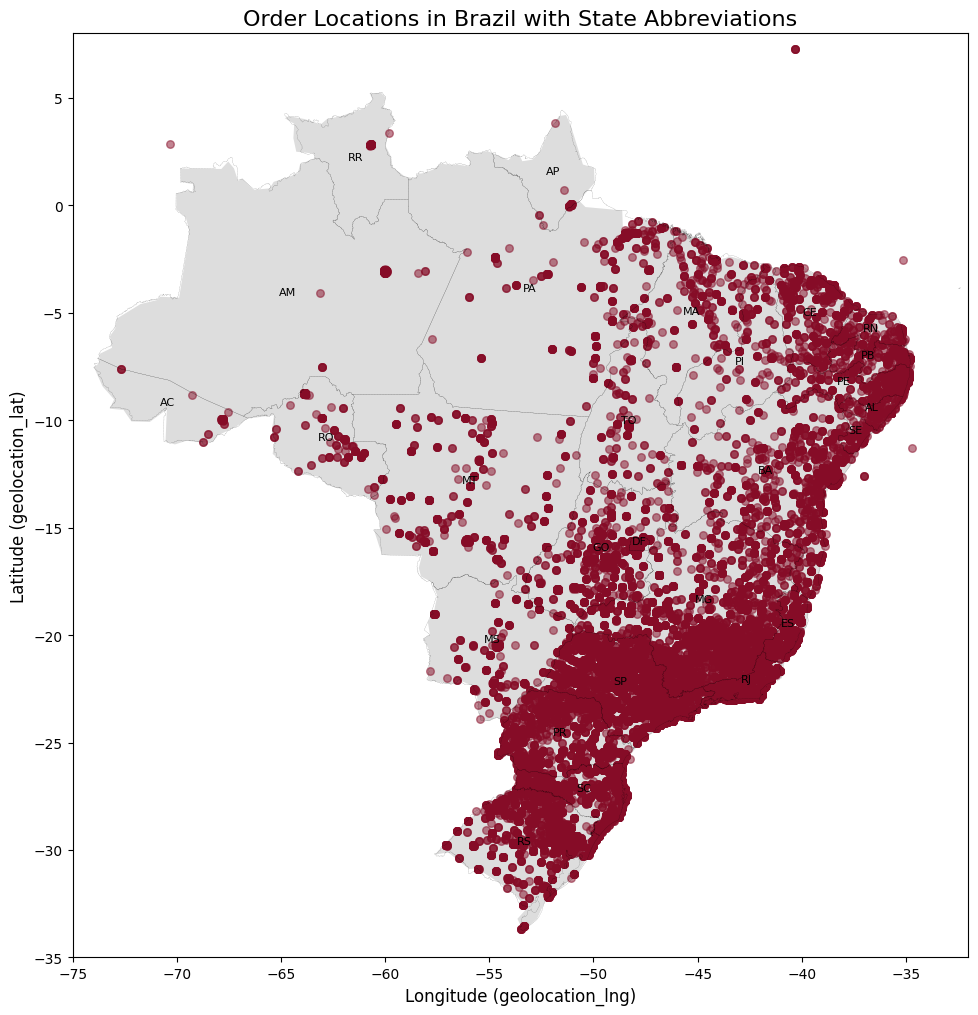

In [68]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 브라질 국가 데이터 로드 (세계 지도)
shapefile_path = "data/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
brazil = world[world['NAME'] == 'Brazil']  # NAME 컬럼 대소문자 확인

# 브라질 주 데이터 로드 (GeoJSON)
geojson_path = "data/brazil-states.geojson"  # GeoJSON 파일 경로
brazil_states = gpd.read_file(geojson_path)

# 브라질 주 약어 추가 (파일에 없다면 추가)
if 'sigla' not in brazil_states.columns:
    brazil_states['sigla'] = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']


# 지도 그리기
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 국가 경계 표시
brazil.plot(ax=ax, color='#ddd', edgecolor='None')

# 브라질 주 경계 표시
brazil_states.boundary.plot(ax=ax, linewidth=0.1, color='black', linestyle="--")

# 주 약어 표시
for idx, row in brazil_states.iterrows():
    plt.text(
        row.geometry.centroid.x,  # 중심 x 좌표
        row.geometry.centroid.y,  # 중심 y 좌표
        row['sigla'],             # 약어 (예: SP)
        fontsize=8,
        ha='center',
        color='black'
    )

# 데이터 산점도 표시
plt.scatter(
    order_customer_geo_df['geolocation_lng'],
    order_customer_geo_df['geolocation_lat'],
    c='#860C27',
    alpha=0.5,
    s=30,
)

plt.xlim(-75, -32)
plt.ylim(-35, 8)

# 제목과 라벨 설정
plt.title('Order Locations in Brazil with State Abbreviations', fontsize=16)
plt.xlabel('Longitude (geolocation_lng)', fontsize=12)
plt.ylabel('Latitude (geolocation_lat)', fontsize=12)

# # 범례 추가
# plt.legend()

# 시각화 표시
plt.show()



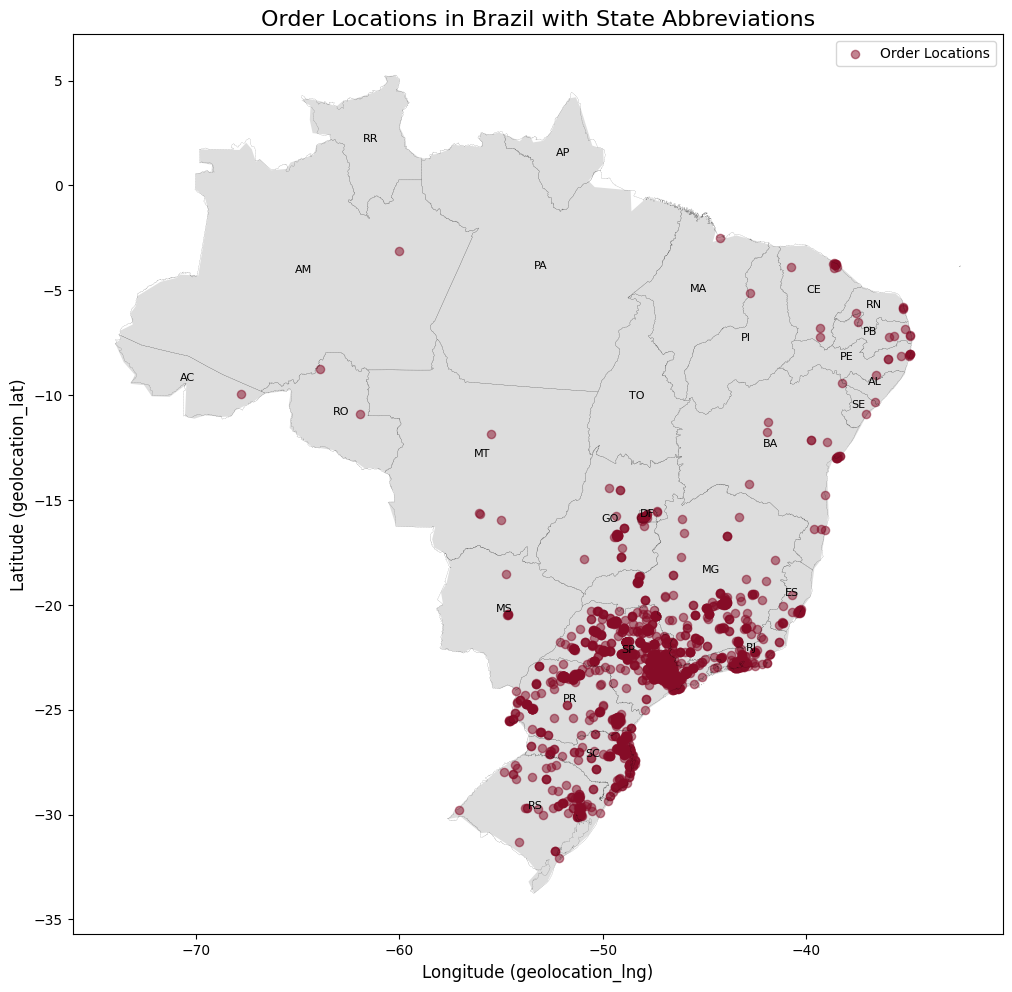

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 브라질 국가 데이터 로드 (세계 지도)
shapefile_path = "data/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
brazil = world[world['NAME'] == 'Brazil']  # NAME 컬럼 대소문자 확인

# 브라질 주 데이터 로드 (GeoJSON)
geojson_path = "data/brazil-states.geojson"  # GeoJSON 파일 경로
brazil_states = gpd.read_file(geojson_path)

# 브라질 주 약어 추가 (파일에 없다면 추가)
if 'sigla' not in brazil_states.columns:
    brazil_states['sigla'] = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']


# 지도 그리기
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 국가 경계 표시
brazil.plot(ax=ax, color='#ddd', edgecolor='None')

# 브라질 주 경계 표시
brazil_states.boundary.plot(ax=ax, linewidth=0.1, color='black', linestyle="--")

# 주 약어 표시
for idx, row in brazil_states.iterrows():
    plt.text(
        row.geometry.centroid.x,  # 중심 x 좌표
        row.geometry.centroid.y,  # 중심 y 좌표
        row['sigla'],             # 약어 (예: SP)
        fontsize=8,
        ha='center',
        color='black'
    )

# 데이터 산점도 표시
plt.scatter(
    geolocation_seller_df['geolocation_lng'],
    geolocation_seller_df['geolocation_lat'],
    c='#860C27',
    alpha=0.5,
    s=35,
    label='Order Locations'
)

# 제목과 라벨 설정
plt.title('Order Locations in Brazil with State Abbreviations', fontsize=16)
plt.xlabel('Longitude (geolocation_lng)', fontsize=12)
plt.ylabel('Latitude (geolocation_lat)', fontsize=12)

# 범례 추가
plt.legend()

# 시각화 표시
plt.show()



### 점유율이 높은 경우의 KMEANS

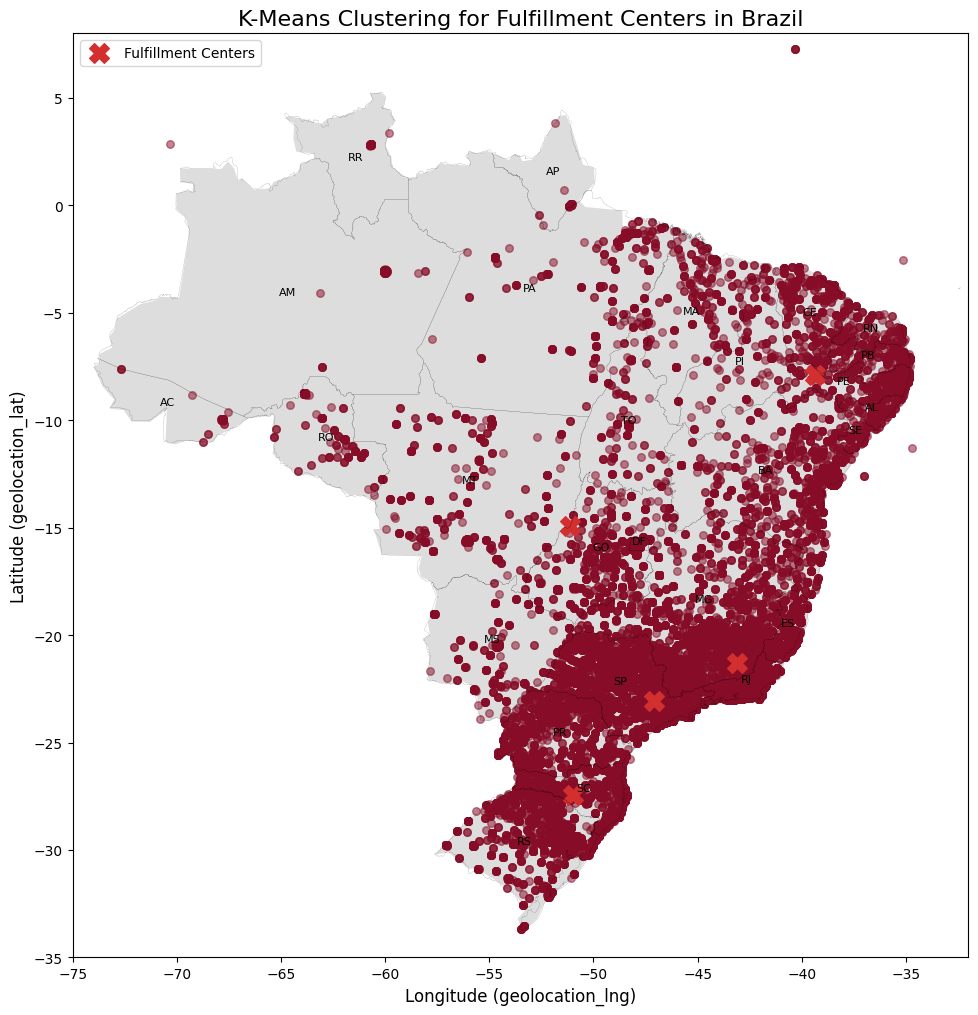

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# 브라질 국가 데이터 로드 (세계 지도)
shapefile_path = "data/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
brazil = world[world['NAME'] == 'Brazil']

order_customer_geo_df = order_customer_geo_df.dropna(subset=['geolocation_lat', 'geolocation_lng']).reset_index(drop=True)

# 브라질 주 데이터 로드 (GeoJSON)
geojson_path = "data/brazil-states.geojson"  # GeoJSON 파일 경로
brazil_states = gpd.read_file(geojson_path)

# 브라질 주 약어 추가 (파일에 없다면 추가)
if 'sigla' not in brazil_states.columns:
    brazil_states['sigla'] = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# 예제 데이터 준비 (위도와 경도 포함)
# order_customer_geo_df에 geolocation_lat와 geolocation_lng 열이 있다고 가정

# K-Means 클러스터링 수행 (3개의 Fulfillment 센터 후보)
order_locations = order_customer_geo_df[['geolocation_lat', 'geolocation_lng']]
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(order_locations)

# 클러스터 중심점 좌표 추출
fulfillment_centers = kmeans.cluster_centers_
# 데이터 산점도 표시

# 지도에 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 국가 경계 표시
brazil.plot(ax=ax, color='#ddd', edgecolor='None')

# 브라질 주 경계 표시
brazil_states.boundary.plot(ax=ax, linewidth=0.1, color='black', linestyle="--")

# 주 약어 표시
for idx, row in brazil_states.iterrows():
    plt.text(
        row.geometry.centroid.x,  # 중심 x 좌표
        row.geometry.centroid.y,  # 중심 y 좌표
        row['sigla'],             # 약어 (예: SP)
        fontsize=8,
        ha='center',
        color='black'
    )

# 기존 주문 위치 (파란색 점)
plt.scatter(
    order_customer_geo_df['geolocation_lng'],
    order_customer_geo_df['geolocation_lat'],
    c='#860C27',
    alpha=0.5,
    s=30,
)

# Fulfillment 센터 후보 위치 (빨간색 X)
plt.scatter(
    fulfillment_centers[:, 1], fulfillment_centers[:, 0],
    c='#D32F2F', s=200, marker='X', label='Fulfillment Centers'
)

# 축 범위 설정
plt.xlim(-75, -32)
plt.ylim(-35, 8)

# 제목과 라벨 설정
plt.title('K-Means Clustering for Fulfillment Centers in Brazil', fontsize=16)
plt.xlabel('Longitude (geolocation_lng)', fontsize=12)
plt.ylabel('Latitude (geolocation_lat)', fontsize=12)

# 범례 추가
plt.legend()

# 시각화 표시
plt.show()

### 점유율이 낮은 케이스의 KMEANS

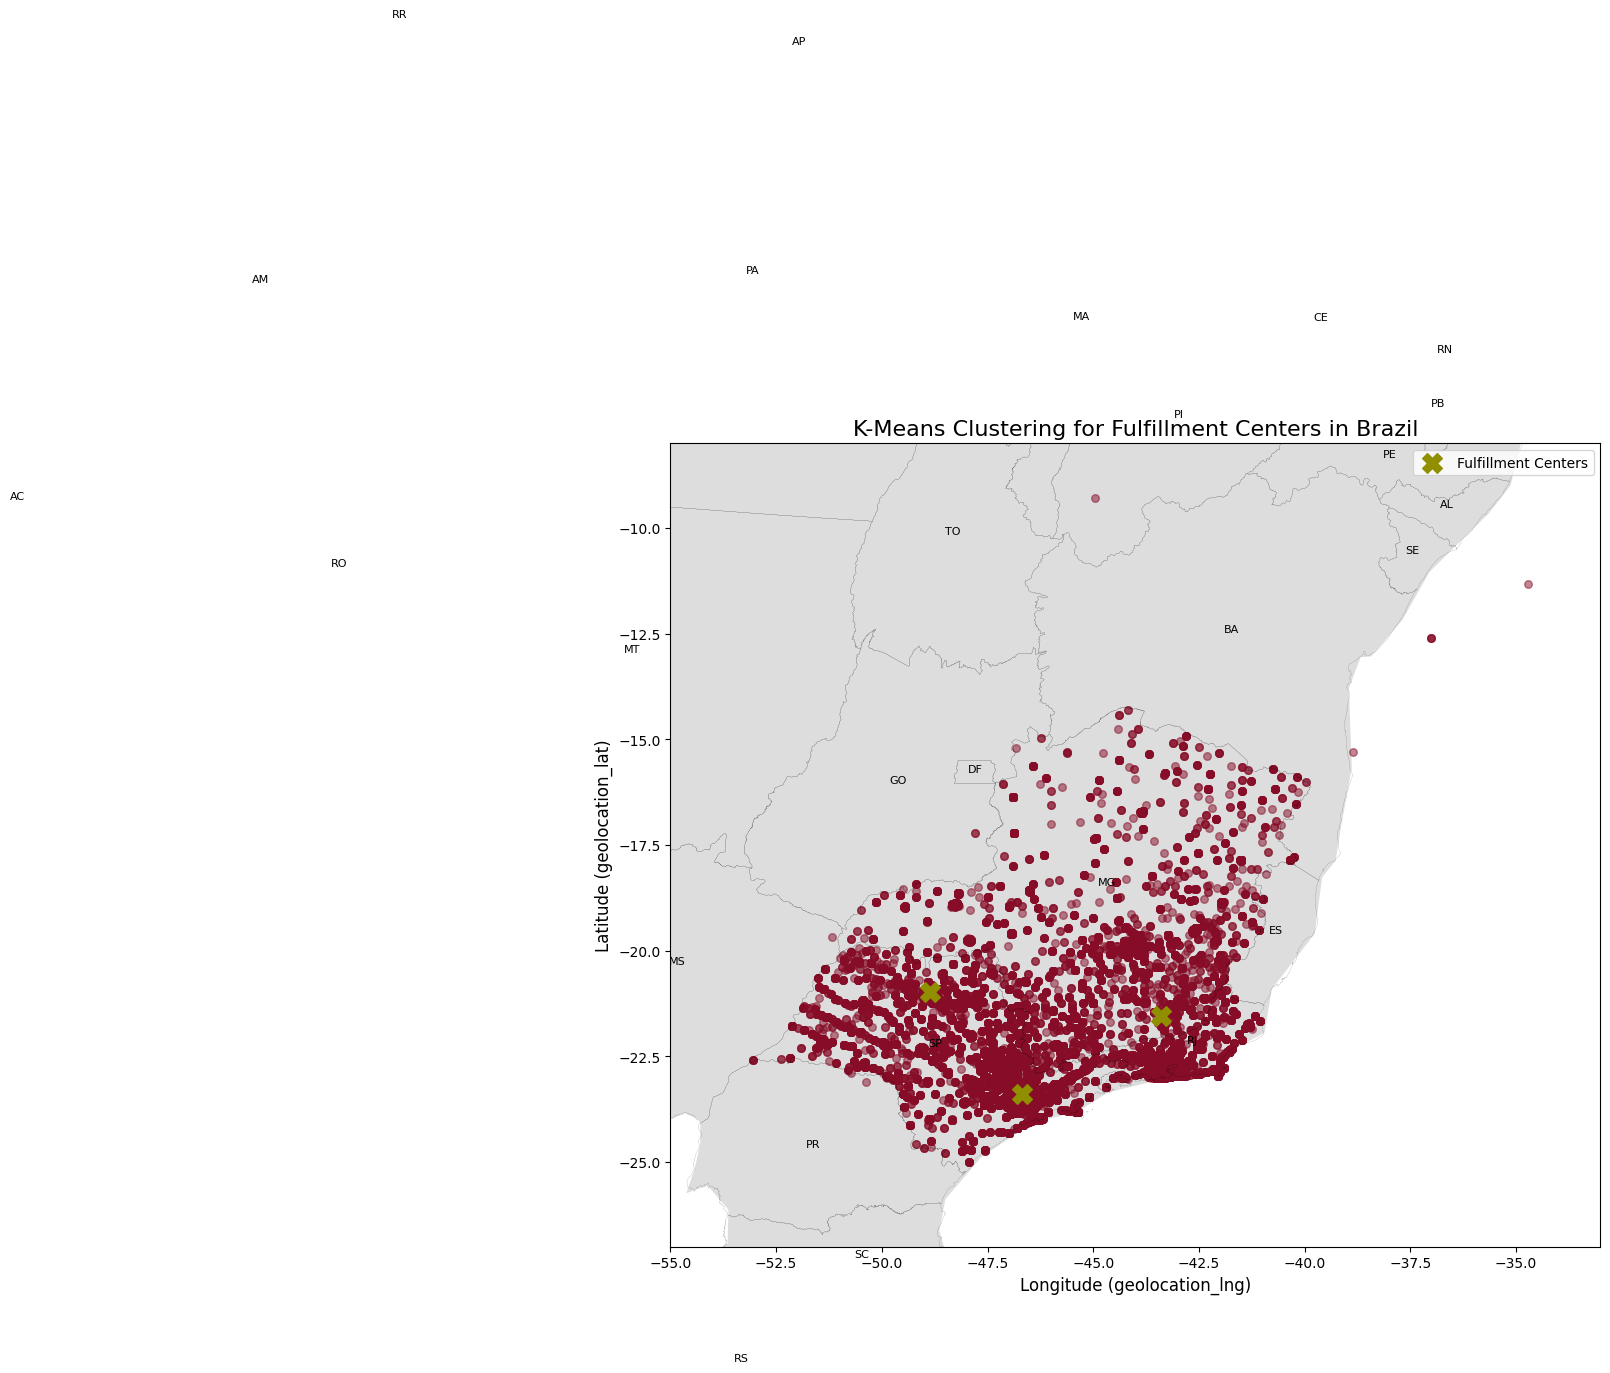

In [73]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# 브라질 국가 데이터 로드 (세계 지도)
shapefile_path = "data/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
brazil = world[world['NAME'] == 'Brazil']

# 고객 위치 데이터 필터링
order_customer_geo_df = order_customer_geo_df[
    (order_customer_geo_df['geolocation_state'] == "MG") |
    (order_customer_geo_df['geolocation_state'] == "RJ") |
    (order_customer_geo_df['geolocation_state'] == "SP")
]
order_customer_geo_df = order_customer_geo_df.dropna(subset=['geolocation_lat', 'geolocation_lng']).reset_index(drop=True)

# 브라질 주 데이터 로드 (GeoJSON)
geojson_path = "data/brazil-states.geojson"  # GeoJSON 파일 경로
brazil_states = gpd.read_file(geojson_path)

# 브라질 주 약어 추가 (파일에 없다면 추가)
if 'sigla' not in brazil_states.columns:
    brazil_states['sigla'] = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# K-Means 클러스터링 수행 (3개의 Fulfillment 센터 후보)
order_locations = order_customer_geo_df[['geolocation_lat', 'geolocation_lng']]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(order_locations)

# 클러스터 중심점 좌표 추출
fulfillment_centers = kmeans.cluster_centers_

# 지도에 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 국가 경계 표시 (지도를 축 크기에 맞추기)
brazil.plot(ax=ax, color='#ddd', edgecolor='None')

# 브라질 주 경계 표시
brazil_states.boundary.plot(ax=ax, linewidth=0.1, color='black', linestyle="--")

# 축 범위를 데이터와 맞추기
min_lng, max_lng = -55, -33
min_lat, max_lat = -27, -8
ax.set_xlim(min_lng, max_lng)
ax.set_ylim(min_lat, max_lat)

# 축 비율 고정 (Equal Aspect Ratio)
ax.set_aspect('equal')

# 주 약어 표시
for idx, row in brazil_states.iterrows():
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        row['sigla'],
        fontsize=8,
        ha='center',
        color='black'
    )

# 기존 주문 위치 (파란색 점)
plt.scatter(
    order_customer_geo_df['geolocation_lng'],
    order_customer_geo_df['geolocation_lat'],
    c='#860C27',
    alpha=0.5,
    s=30,
)

# Fulfillment 센터 후보 위치 (빨간색 X)
plt.scatter(
    fulfillment_centers[:, 1],
    fulfillment_centers[:, 0],
    c='#8F8F00',
    s=200,
    marker='X',
    label='Fulfillment Centers'
)

plt.xlim(-55, -33)
plt.ylim(-27, -8)

# 제목과 라벨 설정
plt.title('K-Means Clustering for Fulfillment Centers in Brazil', fontsize=16)
plt.xlabel('Longitude (geolocation_lng)', fontsize=12)
plt.ylabel('Latitude (geolocation_lat)', fontsize=12)

# 범례 추가
plt.legend()

# 시각화 표시
plt.show()
